# Transfer Learning for Jet Tagging in Particle Physics: GNN

This is the second accompanying notebook for our final project for the CSCI 2470: Deep Learning course. Here, we will present appropriate visualizations of our input data, build and train our models, and present appropriate visualizations of the outputs and results.

*Authors: Jade Ducharme, Egor Serebriakov, Aditya Singh, Anthony Wong*

### Stage 2: Transfer Learning via GNN

The current state-of-the-art jet tagging model uses a Graph Neural Network architecture. Our second goal is then to build a Teacher and a Student GNN and implement transfer learning similarly to what we did with the FCCN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchmetrics
import torch.optim as optim
from torch_geometric.loader import DataLoader
import torch.nn as nn
import seaborn as sns
from preprocess import *
from helper import *

sns.set_theme()
plt.style.use("seaborn-v0_8")

Similarly to the first notebook, we will start by loading in the data and preprocessing. Note that since we are now working with *graphs*, the preprocessing steps will differ significantly!

In [2]:
cons_data, cons_labels, cons_weights, cons_features = get_data("./data/reduced_atlas_dataset.h5", attribute="constituents")

print("---------- Constituent-level data ----------------", "\n")
print("Data shape [input_size, num_features, num_constituents]:", cons_data.shape, "\n")
print("Feature names:", cons_features)
print("Feature names (human-readable):", [human_feature(f) for f in cons_features])

---------- Constituent-level data ---------------- 

Data shape [input_size, num_features, num_constituents]: (10000, 4, 80) 

Feature names: ['fjet_clus_pt' 'fjet_clus_eta' 'fjet_clus_phi' 'fjet_clus_E']
Feature names (human-readable): ['constituent transverse momentum', 'constituent pseudo-rapidity', 'constituent azimuthal angle', 'constituent energy']


To implement our GNN, we then need to form graphs using our data. We will do so using the k-nearest-neighbors algorithm.

In [3]:
from preprocess import prepare_graphs

graphs = prepare_graphs(cons_data, cons_labels, k=8, weights=cons_weights)

#### Visualize

We can visualize the graphs we just created!

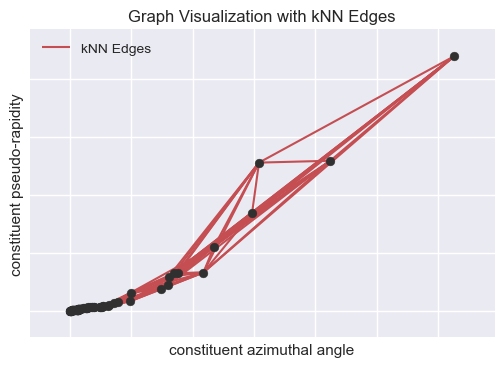

In [4]:
from visualize import visualize_graph

visualize_graph(graphs[9], x_axis='fjet_clus_phi', y_axis='fjet_clus_eta')

#### Build the Teacher GNN

Let's build the Teacher GNN and train it on the high-resolution data:

In [5]:
from model import TeacherGNN
from preprocess import split_graphs
from model import train_one_epoch_gnn, test_gnn

# prepare data
train_dataset, val_dataset, test_dataset = split_graphs(graphs, 0.7, 0.15)

train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=24, shuffle=True)

# Check for CUDA, then default to CPU
# device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# initialize model
teacher_gnn = TeacherGNN().to(device)
optimizer = torch.optim.Adam(teacher_gnn.parameters(), lr=0.005)
criterion = nn.BCELoss(reduction='none')

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

# start training
num_epochs = 10
for e in range(1,num_epochs+1):

    # training
    loss, acc = train_one_epoch_gnn(teacher_gnn, device, train_loader, optimizer, criterion)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test_gnn(teacher_gnn, device, val_loader, criterion)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    # if e%5 == 0:
    print(f"Epoch {e:02d}\t Train loss: {loss:.4f}\t Train acc: {acc:.4f}\t"\
            + f"Val loss: {val_loss:.4f}\t Val acc: {val_acc:.4f}"
)

Device: cpu
Epoch 01	 Train loss: 25.7790	 Train acc: 0.5001	Val loss: 25.4891	 Val acc: 0.4973
Epoch 02	 Train loss: 25.6778	 Train acc: 0.4921	Val loss: 25.6184	 Val acc: 0.4827
Epoch 03	 Train loss: 25.7457	 Train acc: 0.5033	Val loss: 25.5536	 Val acc: 0.4920
Epoch 04	 Train loss: 25.7384	 Train acc: 0.4990	Val loss: 25.4215	 Val acc: 0.5020
Epoch 05	 Train loss: 25.7876	 Train acc: 0.4981	Val loss: 25.6181	 Val acc: 0.4920
Epoch 06	 Train loss: 25.9273	 Train acc: 0.5003	Val loss: 25.5854	 Val acc: 0.4860
Epoch 07	 Train loss: 25.5662	 Train acc: 0.5053	Val loss: 25.6973	 Val acc: 0.5020
Epoch 08	 Train loss: 25.7890	 Train acc: 0.5041	Val loss: 25.4168	 Val acc: 0.4853
Epoch 09	 Train loss: 22.4505	 Train acc: 0.4930	Val loss: 23.9043	 Val acc: 0.5047
Epoch 10	 Train loss: 7.9440	 Train acc: 0.4979	Val loss: 5.5494	 Val acc: 0.4980


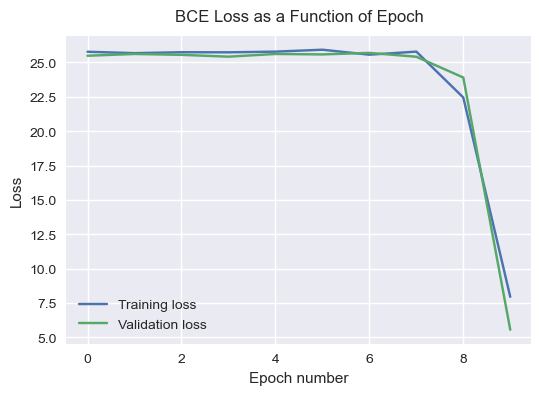

In [6]:
from visualize import plot_accuracy, plot_loss

plot_loss(loss_list, val_loss_list)

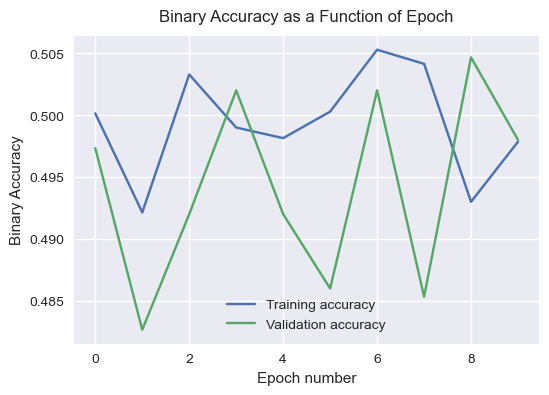

In [7]:
plot_accuracy(acc_list, val_acc_list)

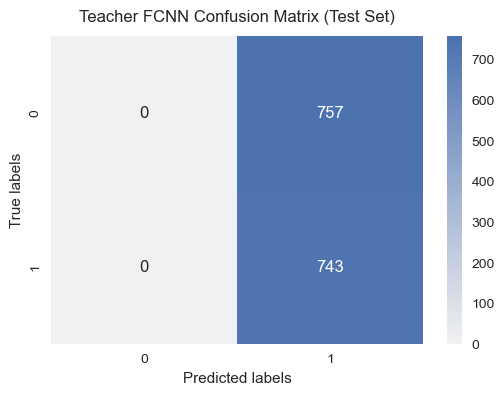

In [8]:
from visualize import plot_confusion_matrices

true = []
pred = []
for d in test_dataset:
    l = d.y.item()
    true.append(int(l))
    pred.append(round(teacher_gnn(d).item()))

plot_confusion_matrices(true, pred, "Teacher FCNN")